In [445]:
%matplotlib inline

### usual imports

In [446]:
import os
import sys
from glob import glob 

In [447]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

### statsmodels 

In [448]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### fbprophet 

In [449]:
from fbprophet import Prophet

In [450]:
from sklearn.metrics import mean_absolute_error as MAE

### 1st example: cycling counts over Tamaki drive 

In [451]:
lfiles = glob('../data/cycling_Auckland/cycling_counts_????.csv')

In [452]:
lfiles.sort()

In [453]:
lfiles

['../data/cycling_Auckland/cycling_counts_2010.csv',
 '../data/cycling_Auckland/cycling_counts_2011.csv',
 '../data/cycling_Auckland/cycling_counts_2012.csv',
 '../data/cycling_Auckland/cycling_counts_2013.csv',
 '../data/cycling_Auckland/cycling_counts_2014.csv',
 '../data/cycling_Auckland/cycling_counts_2015.csv',
 '../data/cycling_Auckland/cycling_counts_2016.csv',
 '../data/cycling_Auckland/cycling_counts_2017.csv',
 '../data/cycling_Auckland/cycling_counts_2018.csv']

In [454]:
l = []
for f in lfiles: 
    d = pd.read_csv(f, index_col=0, parse_dates=True, usecols=['datetime', 'Tamaki Drive EB','Tamaki Drive WB'])
    l.append(d)

In [455]:
df = pd.concat(l, axis=0)

In [456]:
df.head()

In [457]:
df.tail()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2144772f98>,
      dtype=object)

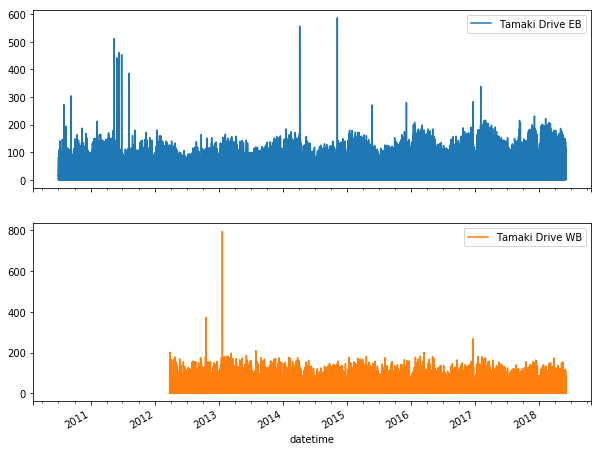

In [458]:
df.plot(subplots=True, figsize=(10, 8))

### seasonal cycle 

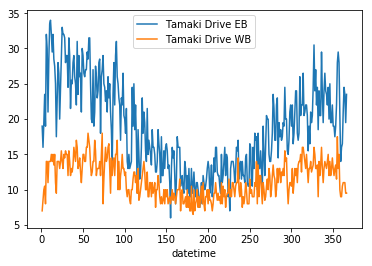

In [459]:
df.groupby(df.index.dayofyear).median().plot()

### weekly cycle 

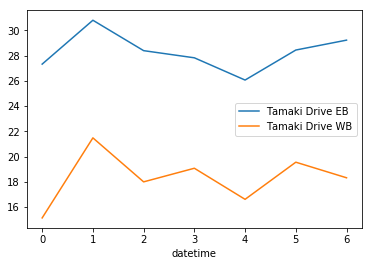

In [460]:
df.groupby(df.index.dayofweek).mean().plot()

### daily cycle 

In [461]:
summary_hour = df.groupby(df.index.hour).describe()

In [462]:
summary_hour.head()

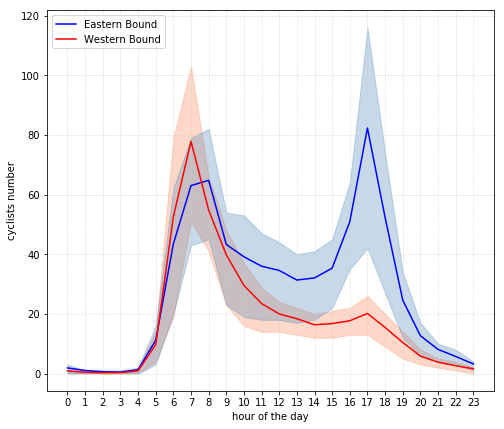

In [463]:

f, ax = plt.subplots(figsize=(8,7))

ax.plot(summary_hour.index, summary_hour.loc[:,('Tamaki Drive EB','mean')], color='b', label='Eastern Bound')
ax.plot(summary_hour.index, summary_hour.loc[:,('Tamaki Drive WB','mean')], color='r', label='Western Bound')

ax.fill_between(summary_hour.index, summary_hour.loc[:,('Tamaki Drive WB','25%')], \
                summary_hour.loc[:,('Tamaki Drive WB','75%')], color='coral', alpha=0.3)

ax.fill_between(summary_hour.index, summary_hour.loc[:,('Tamaki Drive EB','25%')], \
                summary_hour.loc[:,('Tamaki Drive EB','75%')], color='steelblue', alpha=0.3)

ax.legend(loc=2)

ax.set_xticks(range(24));
ax.grid(ls=':', color='0.8')

ax.set_xlabel('hour of the day')

ax.set_ylabel('cyclists number');

### getting rid of the outliers using a median filter 

In [464]:
def median_filter(df, varname = 'Tamaki Drive EB', window=24, std=2): 
    
    dfc = df.copy() 
    
    dfc = dfc.loc[:,[varname]]
    
    dfc['median']= dfc[varname].rolling(window, center=True).median()
    
    dfc['std'] = dfc[varname].rolling(window, center=True).std()
    
    dfc.loc[dfc.loc[:,varname] >= dfc['median']+std*dfc['std'], varname] = np.nan
    
    dfc.loc[dfc.loc[:,varname] <= dfc['median']-std*dfc['std'], varname] = np.nan
    
    return dfc.loc[:, varname]

In [465]:
varname = 'Tamaki Drive EB'

In [466]:
window = 24

In [467]:
df.loc[:,varname] = median_filter(df, varname = varname, window=window, std=2)

In [468]:
varname = 'Tamaki Drive WB'

In [469]:
df.loc[:,varname] = median_filter(df, varname = varname, window=window, std=2)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x214ba5a400>,
      dtype=object)

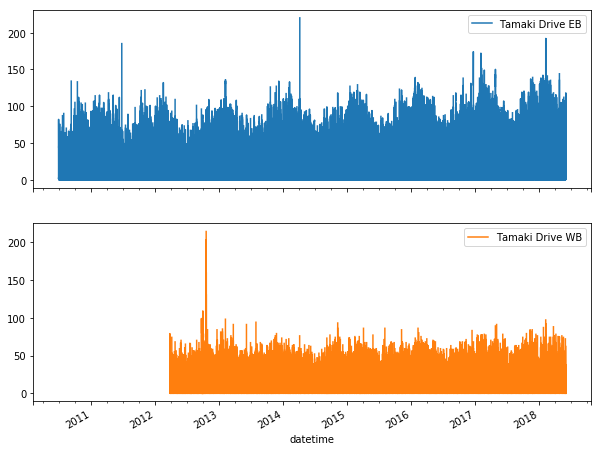

In [470]:
df.plot(subplots=True, figsize=(10, 8))

### resampling at the daily time-step


In [471]:
df = df.resample('1D').sum()

In [472]:
df.head()

In [473]:
df.tail()

### we're goinna look at the cyclists count for Eastern Bound Tamaki Drive ... starting in 2011 as it is when the climate data starts

In [474]:
data = df.loc['2011':,['Tamaki Drive EB']]

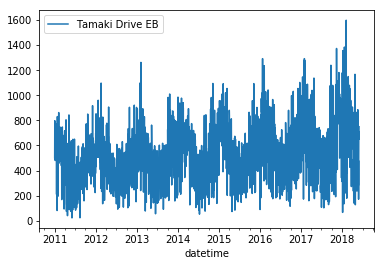

In [475]:
data.plot()

In [476]:
data = data.rename({'Tamaki Drive EB':'y'}, axis=1)

In [477]:
data.tail()

In [478]:
def add_regressor(data, regressor, varname=None): 
    
    """
    adds a regressor to a dataframe of targets
    """
    
    data.loc[:,varname] = regressor.loc[:,varname]
    
    return data

In [479]:
def prepare_data(data, year=2017): 
    
    """
    prepare the data for ingestion by fbprophet: 
    
    1) divide in training and test set, using the `year` parameter (int)
    
    2) reset the index and rename the `datetime` column to `ds`
    
    returns the training and test dataframes
    """
    
    
    data_train = data.loc[:str(year - 1),:]
    
    data_test = data.loc[str(year):,:]
    
    data_train.reset_index(inplace=True)
    
    data_test.reset_index(inplace=True)
    
    data_train = data_train.rename({'datetime':'ds'}, axis=1)
    
    data_test = data_test.rename({'datetime':'ds'}, axis=1)
    
    return data_train, data_test

In [480]:
def make_verif(forecast, data_train, data_test): 
    
    forecast.index = pd.to_datetime(forecast.ds)
    
    data_train.index = pd.to_datetime(data_train.ds)
    
    data_test.index = pd.to_datetime(data_test.ds)
    
    data = pd.concat([data_train, data_test], axis=0)
    
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

In [630]:
def plot_verif(verif, year=2017): 
    
    f, ax = plt.subplots(figsize=(10, 8))
    
    train = verif.loc[:str(year - 1),:]
    
    ax.plot(train.index, train.y, 'ko', markersize=3)
    
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
    
    ax.plot(test.index, test.y, 'ro', markersize=3)
    
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)

In [631]:
def plot_verif_component(verif, component='rain', year=2017): 
    
    f, ax = plt.subplots(figsize=(10, 8))
    
    train = verif.loc[:str(year - 1),:]
        
    ax.plot(train.index, train.loc[:,component], color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.loc[:, component+'_lower'], train.loc[:, component+'_upper'], color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
        
    ax.plot(test.index, test.loc[:,component], color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.loc[:, component+'_lower'], test.loc[:, component+'_upper'], color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)

In [482]:
def add_regressor_to_future(future, regressors_list): 
    
    futures = future.copy() 
    
    futures.index = pd.to_datetime(futures.ds)
    
    regressors = pd.concat(regressors_list, axis=1)
    
    futures = futures.merge(regressors, left_index=True, right_index=True)
    
    futures = futures.reset_index(drop = True) 
    
    return futures

In [483]:
data_train, data_test = prepare_data(data, 2017)

In [484]:
m = Prophet(mcmc_samples=300, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [485]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


In [486]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [487]:
forecast = m.predict(future)

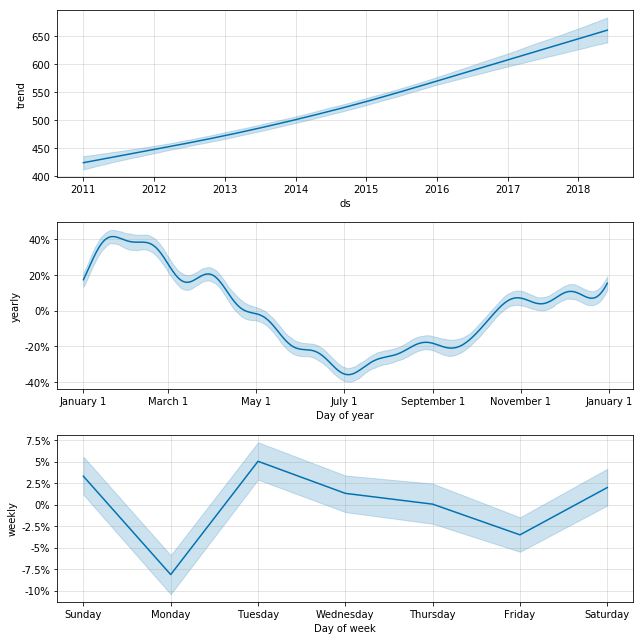

In [488]:
f = m.plot_components(forecast)

In [489]:
verif = make_verif(forecast, data_train, data_test)

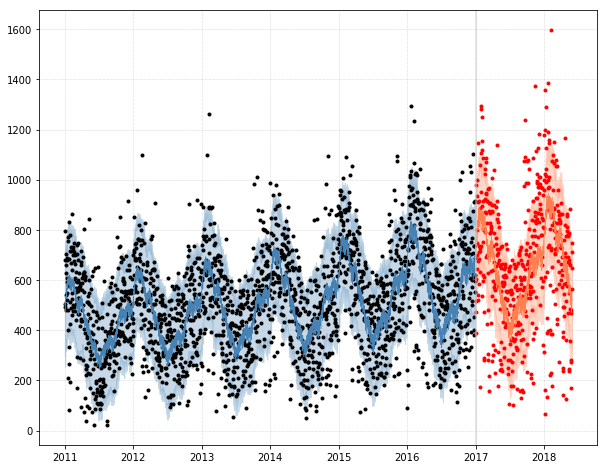

In [490]:
plot_verif(verif)

In [491]:
verif.loc[:'2017',['y','yhat']].corr()

In [492]:
verif.loc['2017':,['y','yhat']].corr()

In [493]:
MAE(verif.y.values, verif.yhat.values)

137.52490404988936

### modelling the effects of the holidays 

In [494]:
holidays_calendar = pd.read_csv('../data/holidays_calendars_2011_2018.csv')

In [495]:
holidays_calendar.loc[:,'ISO_date'] = pd.to_datetime(holidays_calendar.loc[:,'ISO_date'], dayfirst=True)

In [496]:
holidays_calendar = holidays_calendar.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [497]:
holidays_calendar = holidays_calendar.loc[-holidays_calendar.notes.str.contains('Not a public'),:]

In [498]:
holidays = holidays_calendar.loc[(holidays_calendar.loc[:,'Regional'] == 0) | holidays_calendar.RGR.str.contains('Auckland'),:]

In [499]:
holtype = 'category'

In [500]:
if holtype == 'category': 
    holidays = holidays.loc[:,['ISO_date','holiday_category']]
    holidays = holidays.rename({'holiday_category':'holiday'}, axis=1)
if holtype == 'code': 
    holidays = holidays.loc[:,['ISO_date','holiday_code']]
    holidays = holidays.rename({'holiday_code':'holiday'}, axis=1)
else: 
    holidays = holidays.loc[:,['ISO_date','holiday']]

In [501]:
holidays = holidays.rename({'ISO_date':'ds'}, axis=1)

In [502]:
holidays.tail()

In [503]:
m = Prophet(mcmc_samples=300, holidays=holidays, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [504]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/fbprophet-0.3.post2-py3.6.egg/fbprophet/forecaster.py:253: FutureWarning: 'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df = df.sort_values('ds')
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


In [505]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [506]:
forecast = m.predict(future)

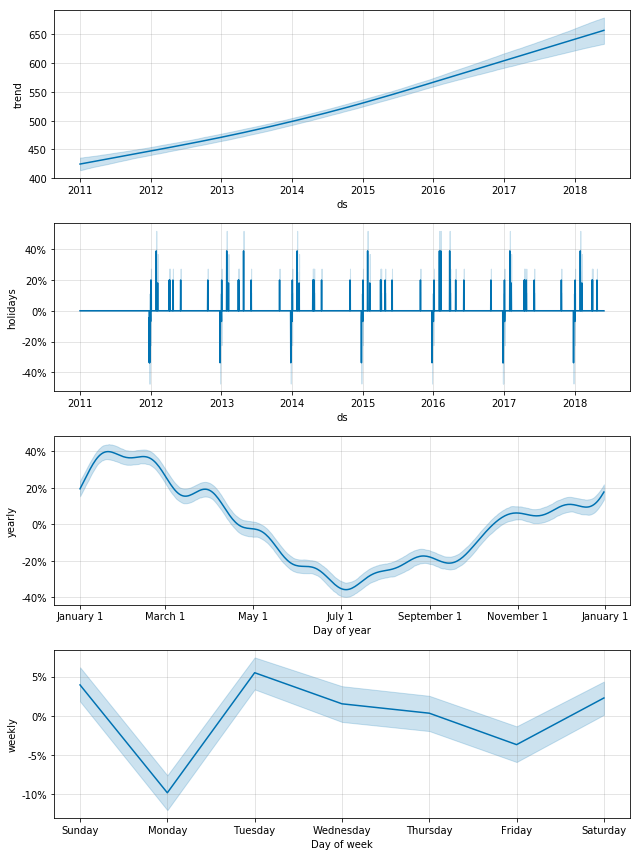

In [507]:
f = m.plot_components(forecast)

In [508]:
verif = make_verif(forecast, data_train, data_test)

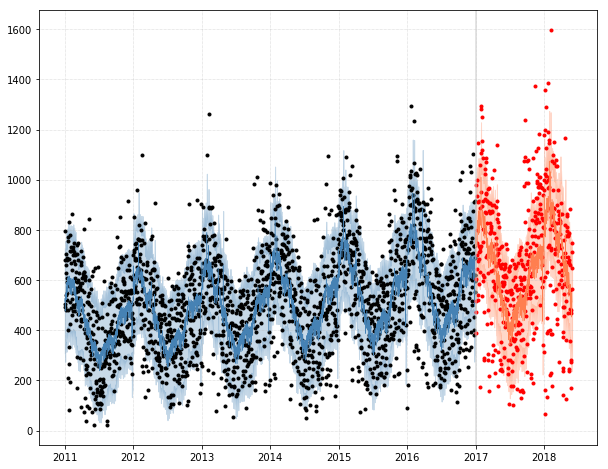

In [509]:
plot_verif(verif)

In [510]:
verif.loc[:'2017',['y','yhat']].corr()

In [511]:
verif.loc['2017':,['y','yhat']].corr()

In [512]:
MAE(verif.y.values, verif.yhat.values)

136.62044783541123

### incorporating the effects of weather conditions

In [575]:
temp = pd.read_csv('../data/weather/Mangere_EWS_temp.csv', index_col=0, parse_dates=True)

In [576]:
rain = pd.read_csv('../data/weather/Mangere_EWS_rain.csv', index_col=0, parse_dates=True)

In [577]:
sun = pd.read_csv('../data/weather/Mangere_EWS_sun.csv', index_col=0, parse_dates=True)

In [578]:
temp = temp.interpolate(method='linear')

In [579]:
rain = rain.interpolate(method='linear')

In [580]:
sun = sun.interpolate(method='linear')

In [543]:
data_with_regressors = add_regressor(data, temp, varname='temp')

In [544]:
data_with_regressors = add_regressor(data_with_regressors, rain, varname='rain')

In [545]:
data_with_regressors = add_regressor(data_with_regressors, sun, varname='sun')

In [582]:
data_with_regressors.head()

In [547]:
data_with_regressors.tail()

In [608]:
data_train, data_test = prepare_data(data_with_regressors, 2017)

In [609]:
m = Prophet(mcmc_samples=300, holidays=holidays, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [610]:
m.add_regressor('temp', prior_scale=0.5, mode='multiplicative')
m.add_regressor('rain', prior_scale=0.5, mode='multiplicative')
m.add_regressor('sun', prior_scale=0.5, mode='multiplicative')

In [611]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


In [612]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [613]:
futures = add_regressor_to_future(future, [temp, rain, sun])

In [614]:
forecast = m.predict(futures)

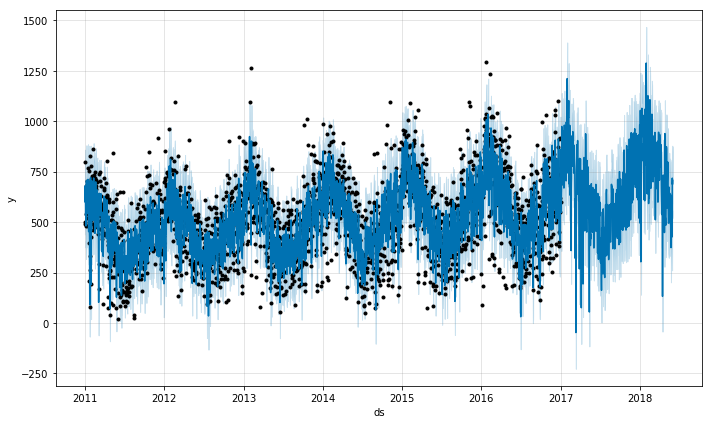

In [615]:
f = m.plot(forecast)

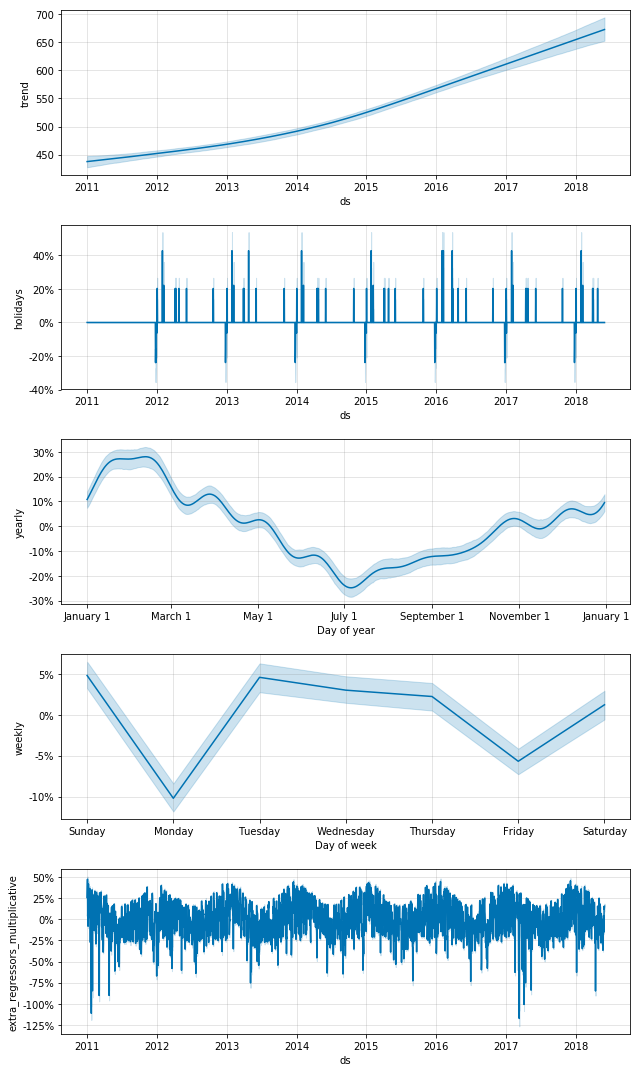

In [616]:
f = m.plot_components(forecast)

In [617]:
verif = make_verif(forecast, data_train, data_test)

In [618]:
verif.head()

In [619]:
verif.loc[:,'yhat'] = verif.yhat.clip_lower(0)

In [620]:
verif.loc[:,'yhat_lower'] = verif.yhat_lower.clip_lower(0)

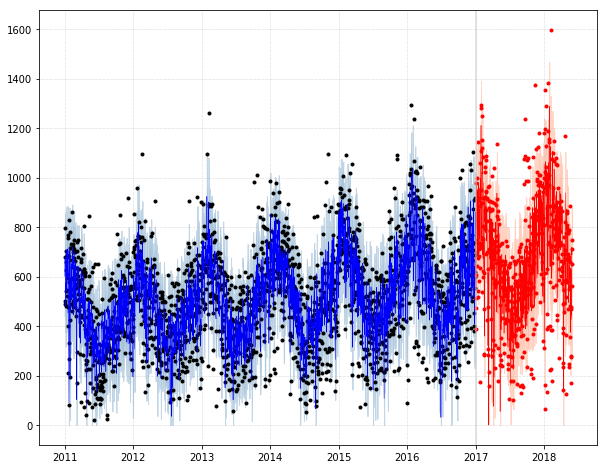

In [621]:
plot_verif(verif)

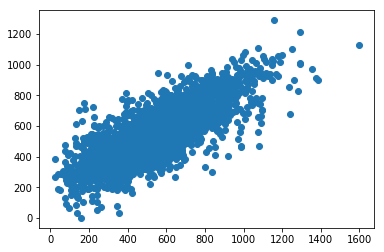

In [622]:
plt.scatter(verif.y, verif.yhat)

In [623]:
verif.loc[:'2017',['y','yhat']].corr()

In [624]:
verif.loc['2017':,['y','yhat']].corr()

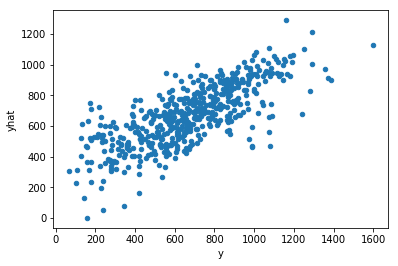

In [625]:
verif.loc['2017':].plot.scatter(x='y',y='yhat')

In [632]:
MAE(verif.y.values, verif.yhat.values)

105.02031269158647

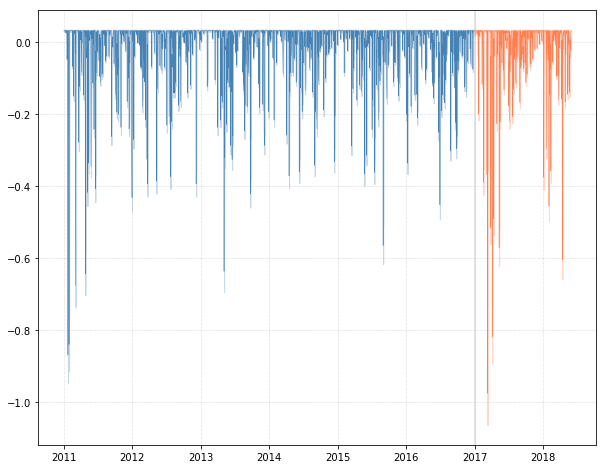

In [633]:
plot_verif_component(verif, component = 'rain')

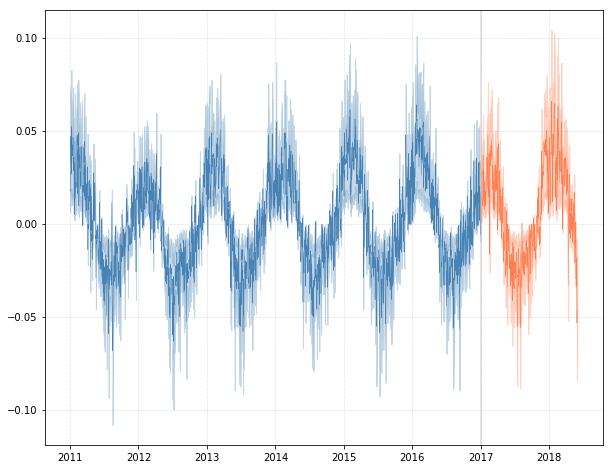

In [634]:
plot_verif_component(verif, component = 'temp')

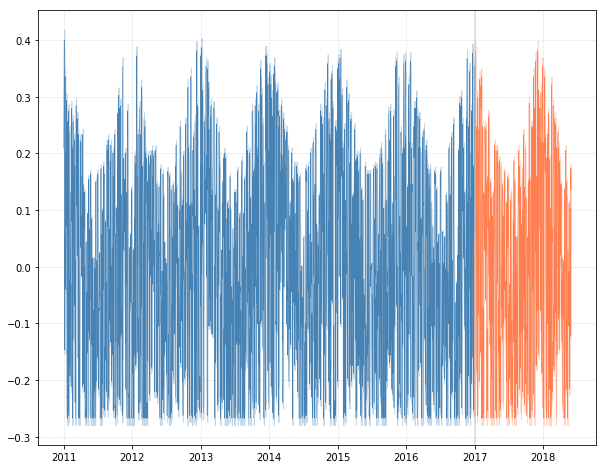

In [635]:
plot_verif_component(verif, component = 'sun')

In [636]:
verif.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'BD', 'BD_lower', 'BD_upper', 'N', 'N_lower', 'N_upper', 'NY',
       'NY_lower', 'NY_upper', 'R', 'R_lower', 'R_upper', 'W', 'W_lower',
       'W_upper', 'X', 'X_lower', 'X_upper', 'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'holidays', 'holidays_lower',
       'holidays_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'rain', 'rain_lower', 'rain_upper', 'sun',
       'sun_lower', 'sun_upper', 'temp', 'temp_lower', 'temp_upper', 'weekly',
       'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'yhat', 'y'],
      dtype='object')

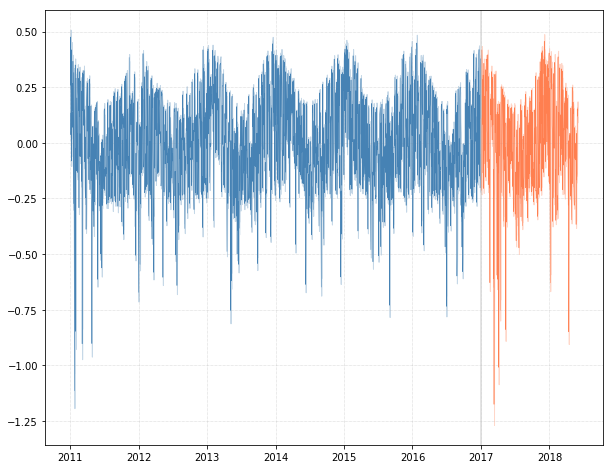

In [645]:
plot_verif_component(verif, component = 'extra_regressors_multiplicative')

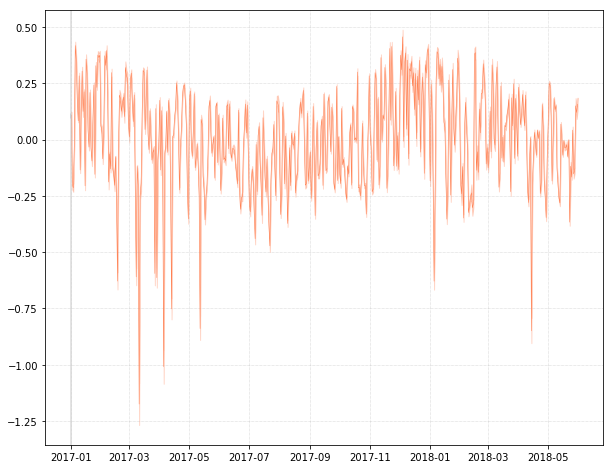

In [643]:
plot_verif_component(verif.loc['2016-12-31':,:], component = 'extra_regressors_multiplicative')